In [99]:
import fbprophet as fb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [7]:
data = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv',index_col=0)
data

,Present Storage(TMC),Reservoir Level(TMC),Inflow,Outflow,MADIKERI,SOMWARPET,VIRAJPET
Dates,,,,,,,
2011-01-01,3.74,2835.90,142.0,0.0,0.0,0.0,0.0
2011-01-02,3.76,2836.09,239.0,0.0,0.0,0.0,0.0
2011-01-03,3.77,2836.22,166.0,0.0,0.0,0.0,0.0
2011-01-04,3.78,2836.31,118.0,0.0,0.0,0.0,0.0
2011-01-05,3.79,2836.41,130.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2018-12-27,1.59,2806.15,103.0,15.0,0.0,0.0,0.0
2018-12-28,1.60,2806.33,98.0,15.0,0.0,0.0,0.0
2018-12-29,1.61,2806.54,102.0,15.0,0.0,0.0,0.0


In [81]:
#dataset preparation with lag
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [197]:
dataset=data.drop(columns = ['Present Storage(TMC)', 'Reservoir Level(TMC)', 'Outflow'])
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values, 3, 1)#lag of 4 days
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
# reframed.drop(reframed.columns[[-2,-3,-4,-5,-6,-7,-8,-9]], axis=1, inplace=True)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
3,142.0,0.0,0.0,0.0,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0
4,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0
5,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0
6,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0
7,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,131.0


In [199]:
print(reframed.tail())
idx = pd.date_range('2011-01-04', '2018-12-31')
idx.shape
reframed['Dates']=idx
reframed.head()

      var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var1(t-2)  var2(t-2)  \
2917       98.0        0.0        0.0        0.0      112.0        0.0   
2918      112.0        0.0        0.0        0.0       98.0        0.0   
2919       98.0        0.0        0.0        0.0      103.0        0.0   
2920      103.0        0.0        0.0        0.0       98.0        0.0   
2921       98.0        0.0        0.0        0.0      102.0        0.0   

      var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  \
2917        0.0        0.0       98.0        0.0        0.0        0.0   
2918        0.0        0.0      103.0        0.0        0.0        0.0   
2919        0.0        0.0       98.0        0.0        0.0        0.0   
2920        0.0        0.0      102.0        0.0        0.0        0.0   
2921        0.0        0.0       99.0        0.0        0.0        0.0   

      var1(t)  
2917    103.0  
2918     98.0  
2919    102.0  
2920     99.0  
2921     99.0  


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),Dates
3,142.0,0.0,0.0,0.0,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0,2011-01-04
4,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0,2011-01-05
5,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0,2011-01-06
6,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0,2011-01-07
7,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0,131.0,2011-01-08


In [67]:
min(data.Inflow)

0.0

In [68]:
y_axis = data.Inflow

In [69]:
x_axis = data.MADIKERI

In [299]:
data=data.iloc[:-365,:]

In [70]:
high=max(data.Inflow)

In [200]:
data1 = reframed #data.drop(columns = ['Present Storage(TMC)','Reservoir Level(TMC)','Outflow','SOMWARPET','VIRAJPET'])

In [201]:
data1= data1.set_index('Dates')

In [202]:
data1.columns

Index(['var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var1(t-2)',
       'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var3(t-1)', 'var4(t-1)', 'var1(t)'],
      dtype='object')

In [203]:
df = pd.DataFrame(reframed[['Dates','var1(t)','var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var1(t-2)',
       'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var3(t-1)', 'var4(t-1)']])
# df.drop(columns = ['Inflow','MADIKERI'],inplace = True)
df

,Dates,var1(t),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1)
3,2011-01-04,118.0,142.0,0.0,0.0,0.0,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0
4,2011-01-05,130.0,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0
5,2011-01-06,167.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0
6,2011-01-07,149.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0
7,2011-01-08,131.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,103.0,98.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0
2918,2018-12-28,98.0,112.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0
2919,2018-12-29,102.0,98.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0
2920,2018-12-30,99.0,103.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0


In [204]:
# mix = np.mat(data1.loc[:,['Inflow','MADIKERI']])
# mix[0]
# a = list()
# for i in range(len(mix)):
#     a.append(list(np.array(mix[i])))
# a = np.array(a)
# print(a.shape)
# a.reshape(2922,2)

In [205]:
df = df.rename(columns = {'Dates':'ds','var1(t)':'y'})
# df = df.iloc[:-365,:]
df

,ds,y,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1)
3,2011-01-04,118.0,142.0,0.0,0.0,0.0,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0
4,2011-01-05,130.0,239.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0
5,2011-01-06,167.0,166.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0
6,2011-01-07,149.0,118.0,0.0,0.0,0.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0
7,2011-01-08,131.0,130.0,0.0,0.0,0.0,167.0,0.0,0.0,0.0,149.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,103.0,98.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0
2918,2018-12-28,98.0,112.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0
2919,2018-12-29,102.0,98.0,0.0,0.0,0.0,103.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0
2920,2018-12-30,99.0,103.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0


In [246]:
m = fb.Prophet(daily_seasonality = True)
m.add_seasonality(name='weekly', period=10, fourier_order=50)
# m.add_seasonality(name='six', period=4, fourier_order=4)
# m.add_regressor('Inflow')
for i in range(12):
    m.add_regressor(data1.columns[i])
# m.add_regressor('MADIKERI')
# m.add_regressor('SOMWARPET')
# m.add_regressor('VIRAJPET')

df_train = df.loc[df["ds"]<="2013-12-31"]
df_test  = df.loc[df["ds"]>="2015-01-01"]
df_test

,ds,y,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1)
1461,2015-01-01,956.0,50.0,1.754765,6.028740,0.062660,72.0,1.784507,6.130188,0.062254,514.0,1.814249,6.231636,0.061847
1462,2015-01-02,168.0,72.0,1.784507,6.130188,0.062254,514.0,1.814249,6.231636,0.061847,956.0,1.843991,6.333083,0.061440
1463,2015-01-03,160.0,514.0,1.814249,6.231636,0.061847,956.0,1.843991,6.333083,0.061440,168.0,1.873732,6.434531,0.061033
1464,2015-01-04,148.0,956.0,1.843991,6.333083,0.061440,168.0,1.873732,6.434531,0.061033,160.0,1.903474,6.535978,0.060626
1465,2015-01-05,152.0,168.0,1.873732,6.434531,0.061033,160.0,1.903474,6.535978,0.060626,148.0,1.933216,6.637426,0.060219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,103.0,98.0,0.000000,0.000000,0.000000,112.0,0.000000,0.000000,0.000000,98.0,0.000000,0.000000,0.000000
2918,2018-12-28,98.0,112.0,0.000000,0.000000,0.000000,98.0,0.000000,0.000000,0.000000,103.0,0.000000,0.000000,0.000000
2919,2018-12-29,102.0,98.0,0.000000,0.000000,0.000000,103.0,0.000000,0.000000,0.000000,98.0,0.000000,0.000000,0.000000
2920,2018-12-30,99.0,103.0,0.000000,0.000000,0.000000,98.0,0.000000,0.000000,0.000000,102.0,0.000000,0.000000,0.000000


In [247]:
m.fit(df_train)

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.


In [248]:
forecast = m.predict(df_test.drop(columns="y"))

In [59]:
res=m.make_future_dataframe(periods=70)
# res['Inflow']=
forecast = m.predict(res)

In [51]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,0.013311,-0.002931,0.033306,0.011657,0.015135,0.001303,0.001303,0.001303,0.011463,...,0.001622,0.001622,0.001622,-0.005793,-0.005793,-0.005793,0.0,0.0,0.0,0.014614
1,2015-01-02,0.013323,-0.002221,0.035833,0.011665,0.015154,0.003279,0.003279,0.003279,0.011463,...,0.001023,0.001023,0.001023,-0.005851,-0.005851,-0.005851,0.0,0.0,0.0,0.016603
2,2015-01-03,0.013336,-0.003966,0.033811,0.011672,0.015173,0.002125,0.002125,0.002125,0.011463,...,-0.000243,-0.000243,-0.000243,-0.005900,-0.005900,-0.005900,0.0,0.0,0.0,0.015460
3,2015-01-04,0.013348,-0.004501,0.031652,0.011680,0.015194,-0.000136,-0.000136,-0.000136,0.011463,...,-0.001025,-0.001025,-0.001025,-0.005937,-0.005937,-0.005937,0.0,0.0,0.0,0.013212
4,2015-01-05,0.013360,-0.009140,0.028232,0.011685,0.015214,-0.003211,-0.003211,-0.003211,0.011463,...,-0.001998,-0.001998,-0.001998,-0.005961,-0.005961,-0.005961,0.0,0.0,0.0,0.010149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2018-12-25,0.031027,0.001112,0.054577,0.011441,0.051126,-0.002721,-0.002721,-0.002721,0.011463,...,-0.000234,-0.000234,-0.000234,-0.005313,-0.005313,-0.005313,0.0,0.0,0.0,0.028306
1455,2018-12-26,0.031039,0.004398,0.056016,0.011433,0.051155,-0.001650,-0.001650,-0.001650,0.011463,...,0.000854,0.000854,0.000854,-0.005373,-0.005373,-0.005373,0.0,0.0,0.0,0.029389
1456,2018-12-27,0.031051,0.003138,0.056881,0.011425,0.051185,-0.000944,-0.000944,-0.000944,0.011463,...,0.001622,0.001622,0.001622,-0.005439,-0.005439,-0.005439,0.0,0.0,0.0,0.030107
1457,2018-12-28,0.031063,0.003095,0.056177,0.011417,0.051214,-0.001608,-0.001608,-0.001608,0.011463,...,0.001023,0.001023,0.001023,-0.005510,-0.005510,-0.005510,0.0,0.0,0.0,0.029455


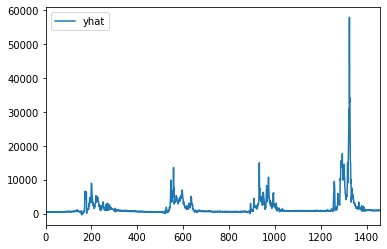

In [249]:
forecast.plot(y='yhat')

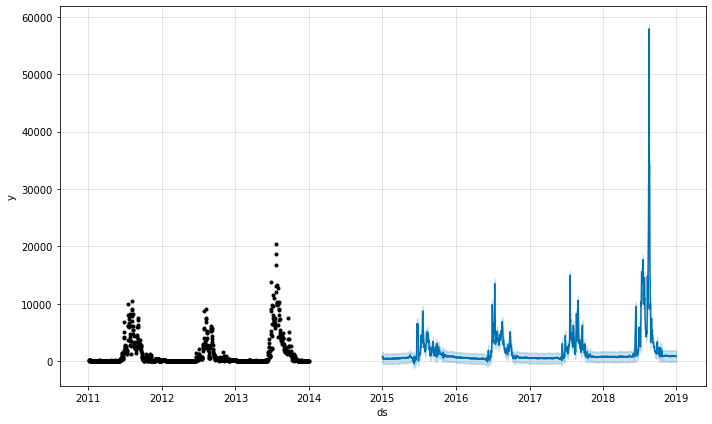

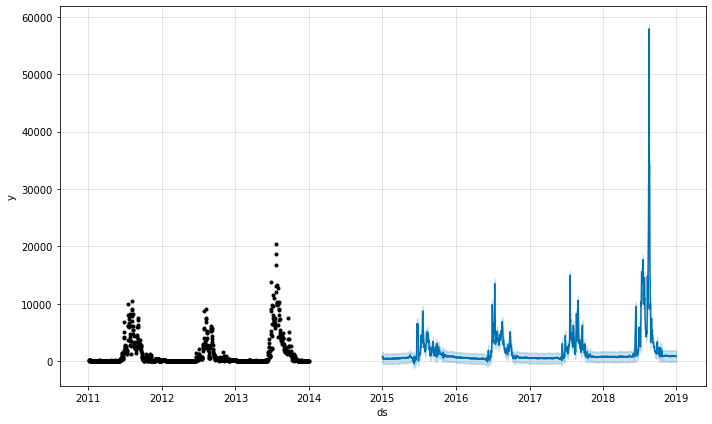

In [221]:
m.plot(forecast)

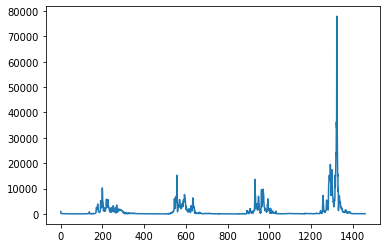

In [211]:
tar = np.array(df_test.iloc[:,1])
plt.plot(tar)

In [94]:
sm = min(tar)
high = max(tar)

In [95]:
max(forecast.loc[:,'yhat'])

34608.87053949442

In [96]:
min(forecast.loc[:,'yhat'])

-1234.9840284029028

In [250]:
info = np.array(forecast.loc[:,'yhat'])

In [188]:
info.shape[0]

1461

In [106]:
info.reshape(info.shape[0],-1,1)

array([[[ 869.03269954]],

       [[1025.33937885]],

       [[ 935.46858724]],

       ...,

       [[1271.18105094]],

       [[1219.23455848]],

       [[1112.15581989]]])

In [107]:
fore = forecast

In [108]:
fore=fore.set_index('ds')

In [118]:
scaler = MinMaxScaler(feature_range=(-1234.9840284029028, high))
scaled = scaler.fit_transform(fore.values)

In [119]:
scaled.shape

(1459, 72)

In [120]:
scaled[:,-1]

array([3410.2008204 , 3755.29000568, 3556.87597505, ..., 4298.05185506,
       4183.36595143, 3946.96073302])

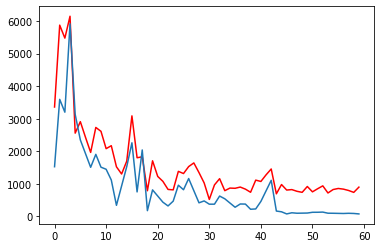

In [251]:
plt.plot(info[991:1051],color='red')
plt.plot(tar[990:1050])

In [252]:
print(sqrt(mean_squared_error(tar[:-1],info[1:])))

1018.3960794064574


In [22]:
df_test['ds']

,ds,y,Inflow,MADIKERI,SOMWARPET,VIRAJPET
1461,2015-01-01,1461,956.0,1.843991,6.333083,0.061440
1462,2015-01-02,1462,168.0,1.873732,6.434531,0.061033
1463,2015-01-03,1463,160.0,1.903474,6.535978,0.060626
1464,2015-01-04,1464,148.0,1.933216,6.637426,0.060219
1465,2015-01-05,1465,152.0,1.962958,6.738873,0.059812


In [331]:
high=max(df_test.iloc[:,2])

In [335]:
min(df_test.iloc[:,2])

3.0